# Optical FLow - Lucas-kanade Algorithm


*   Akshay Bankar (2019201011)

Optical flow is the pattern of apparent motion of image objects between two consecutive frames caused by the movemement of object or camera. It is 2D vector field where each vector is a displacement vector showing the movement of points from first frame to second.

Optical flow works on several assumptions:


1.  The pixel intensities of an object do not change between consecutive frames.
2.  Neighbouring pixels have similar motion.

Consider a pixel *I(x,y,t)* in first frame It moves by distance *(dx,dy)* in next frame taken after dt time. So since those pixels are the same and intensity does not change, we can say,

\begin{equation*}
I(x,y,t) = I(x+dx, y+dy, t+dt)
\end{equation*}

The, take the Taylor series approximation of RHS,
\begin{equation}
I(x+\Delta x,y+\Delta y,t+\Delta t) = I(x,y,t) + \frac{\partial I}{\partial x}\Delta x+\frac{\partial I}{\partial y}\Delta y+\frac{\partial I}{\partial t}\Delta t+H.O.T.
\end{equation}
<br>
From Equation 1 we have
\begin{equation*}
f_x u + f_y v + f_t = 0 \;
\end{equation*}

where

\begin{equation*}
f_x = \frac{\partial f}{\partial x} \; ; \; f_y = \frac{\partial f}{\partial y}
\end{equation*}

and
<br>
\begin{equation*}
u = \frac{dx}{dt} \; ; \; v = \frac{dy}{dt}
\end{equation*}


## Lucas-Kanade method :
Lucas-Kanade method takes a 3x3 patch around the point. So all the 9 points have the same motion. We can find ($f_x$, $f_y$, $f_t$) for these 9 points.
So now our problem becomes solving 9 equations with two unknown variables which is over-determined. A better solution is obtained with least square fit method. Below is the final solution of this least-square method :

\begin{equation*}
\begin{bmatrix} u \\ v \end{bmatrix} = \begin{bmatrix} \sum_{i}{f_{x_i}}^2 & \sum_{i}{f_{x_i} f_{y_i} } \\ \sum_{i}{f_{x_i} f_{y_i}} & \sum_{i}{f_{y_i}}^2 \end{bmatrix}^{-1} \begin{bmatrix} - \sum_{i}{f_{x_i} f_{t_i}} \\ - \sum_{i}{f_{y_i} f_{t_i}} \end{bmatrix}
\end{equation*}
    
    






In [0]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
#from pylab import *
import cv2
import random

%matplotlib inline

def optical_flow(I1g, I2g, window_size=2, tau=1e-2):

    #--- Define kernel to find derivatives in x,y,t-directions ---#
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    #--- Window size over which optical flow is computed ---#
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1 = np.array(I1g)
    I2 = np.array(I2g)
    S = np.shape(I1)
    #--- Normalize image pixels ---#
    I1g = I1g / 255.
    I2g = I2g / 255.
    #--- Lucas Kanade implementation ---#
    #--- For each point, calculate the derivative I_x, I_y, I_t ---#
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + \
         signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)

    #--- Velocity u and v ---#
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            A = [ [ np.sum(Ix*Ix),np.sum(Ix*Iy)], [np.sum(Iy*Ix), np.sum(Iy*Iy)] ]
            A = np.array(A)
    
            b = [-np.sum(Ix*It), -np.sum(Iy*It)]
            b = np.array(b)
            #--- To calculate A_inv*b, find A_inv using SVD decomposition ---#
            #--- If threshold τ is larger than the smallest eigenvalue of A'A:
            U,D,V_T = np.linalg.svd(A.T.dot(A))
            if np.min(D) < tau:
                u[i,j]=0
                v[i,j]=0                
            
            else:
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)

    return np.dstack((u, v))

#--- Function to draw optical flow ---#    
def draw_flow(img, img_gray, flow):
    x = np.arange(0, img_gray.shape[1], 1)
    y = np.arange(0, img_gray.shape[0], 1)
    x, y = np.meshgrid(x, y)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    ax1.imshow(img_gray, cmap='gray', interpolation='bicubic')
    ax1.axis('off')
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    step = img_gray.shape[0] / 20
    step = int(step)
    ax1.quiver(x[::step, ::step], y[::step, ::step],flow[::step, ::step, 0], flow[::step, ::step, 1],
               color='r', pivot='middle', headwidth=1, headlength=5)
    
    hsv = np.zeros_like(img)
    hsv[..., 1] = 255
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    ax2.axis("off")
    ax2.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
    ax2.axis("off")
    prvs = next

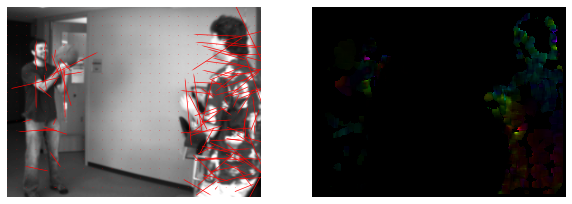

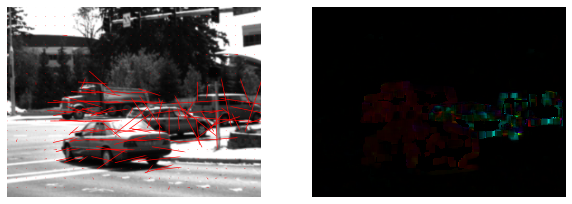

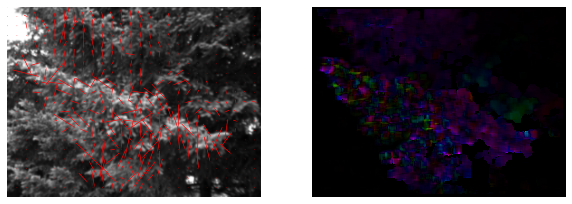

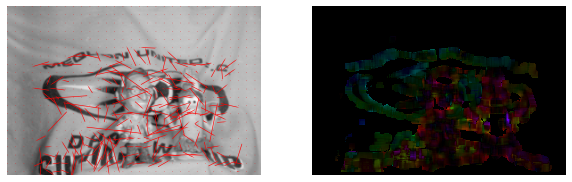

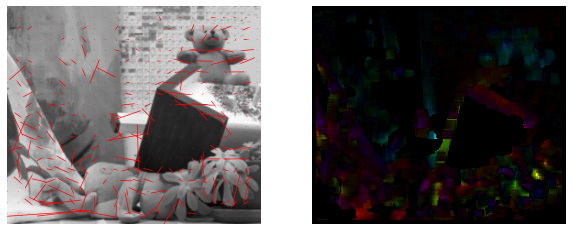

In [0]:
base_path = './dataset/eval-gray-twoframes/eval-data-gray/'
image_pairs = ['Basketball/', 'Dumptruck/', 'Evergreen/', 'Mequon/', 'Teddy/' ]
for img in image_pairs:
    im1 = cv2.imread(base_path+img+'frame10.png')
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.imread(base_path+img+'frame11.png')
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    flow = optical_flow(im1_gray, im2_gray, 15)
    draw_flow(im1, im1_gray, np.array(flow))
#print(np.shape(flow))

### Detection and Segmentation of moving objects

The moving objects can be detected by thresholding the velocity values. The pixels having higher magnitude of flow can be clustered to form a object.

Following are steps :
*  Get the flow between consecutive frames of a video
*  Using cv2.cartToPolar() function get the magnitude of flow
*  Apply thresholds and convert the magnitude array to hsv for better visualization


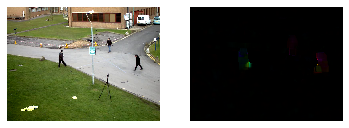

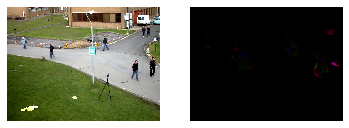

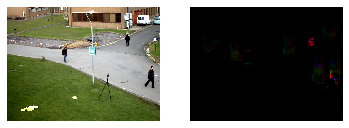

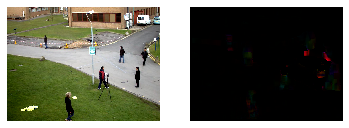

In [0]:
cap = cv2.VideoCapture("vtest.avi")
ret, frame1 = cap.read()
if frame1 is None:
    print(ret)
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
count = -1
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20.0, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
while True:
    ret, frame2 = cap.read()
    count += 1
    if count % 200 != 0:
        continue
    if ret is False:
        break
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    flow = optical_flow(prvs, next, 24)

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    #out.write(rgb)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    prvs = next
    
cap.release()
cv2.destroyAllWindows()

### Tracking of objects in a video sequence

Once we have the optical flow, the moving objects can be tracked if the pixels with similar velocity can be clustered. To cluster we form contours from the pixel velocity i.e nearby pixels with similar velocity are enclosed within a contour. Then a bounding box around the largest contour will provide the object tracking.

Steps:

*  Get the flow between consecutive frames of a video.
*  Using cv2.cartToPolar() function get the magnitude of flow.
*  Convert the magnitude array to hsv and apply thresholds such that we get areas which have considerable velocity and are moving.
*  Find the contours using cv2.findContours() method from the thresholded magnitude array. The function finds largest convex hull around the set of points which are are considerable distances.
*  Draw bounded boxes for the different countours using cv2.boundingRect(). This function takes the contour returned by cv2.findcontours() and returns the largest bounding box which encloses the contour.


In [0]:
def draw_hsv(flow, prev, change=True):
    hsv = np.zeros_like(prev)
    hsv[..., 1] = 255
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    if change:
        hsv = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return hsv

In [0]:
def track_moving_objects(frame, prev):
    def gray(img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    flow = optical_flow(gray(prev), gray(frame), 24)
    hsv1 = draw_hsv(flow, prev)
    gray1 = cv2.cvtColor(hsv1, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray1, 25, 0xFF, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=5)

    cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                                      cv2.CHAIN_APPROX_SIMPLE)

    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 15 and h > 15 and w < 900 and h < 680:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0xFF, 0), 4)
    return frame

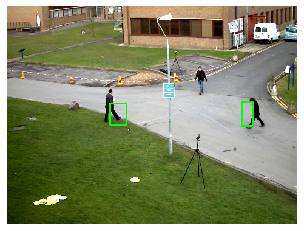

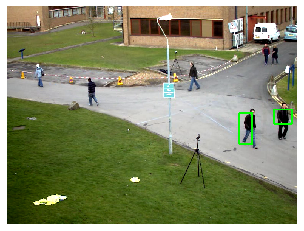

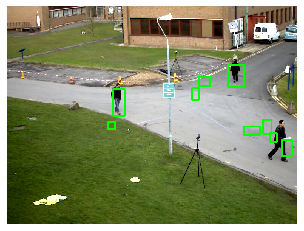

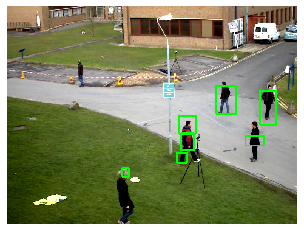

In [0]:
cap = cv2.VideoCapture("vtest.avi")
ret, frame1 = cap.read()
count = -1
out = cv2.VideoWriter('Obj_detect.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20.0, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
while True:
    ret, frame2 = cap.read()
    count += 1
    if count % 200 != 0:
        continue
    if ret is False:
        break
    objected_frame = track_moving_objects(frame2, frame1)
    #out.write(frame2)
    plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    prvs = next
cap.release()